# Morpion Solitaire: exploration with a model

In [1]:
import sys, os
sys.path.append(os.getcwd() + '/../cpp/bin')

import PyMorpionSolitaire

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

## Model

In [4]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [5]:
net = torch.load('models/model-64-res-4.pt', map_location=device)
net.eval()

Sequential(
  (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): ResNet(
    (module): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (11): ResNet(
    (module): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## Game

In [6]:
game = PyMorpionSolitaire.Game5T('c')

In [7]:
state = game.image()[48:144, 48:144]
actions = game.getMoveImages()[:, 48:144, 48:144]

state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
actions = actions ^ state

x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
x.shape

torch.Size([28, 2, 96, 96])

In [8]:
with torch.no_grad():
    y = net(x).data

In [9]:
y.min().item(), y.mean().item(), y.max().item()

(0.0022752881050109863, 0.011451019905507565, 0.024571049958467484)

  0   0.002   0.011   0.025
  1   0.005   0.011   0.018
  2   0.003   0.009   0.016
  3   0.004   0.010   0.017
  4   0.002   0.007   0.013
  5   0.001   0.006   0.012
  6  -0.001   0.005   0.014
  7  -0.001   0.004   0.012
  8  -0.003   0.002   0.008
  9  -0.002   0.003   0.007
 10  -0.002   0.001   0.005
 11  -0.004   0.000   0.005
 12   0.002   0.004   0.006
 13  -0.001   0.003   0.006
 14  -0.005   0.002   0.006
 15   0.005   0.009   0.014
 16  -0.000   0.004   0.009
 17  -0.005   0.004   0.012
 18  -0.005   0.003   0.006
 19  -0.005   0.004   0.008
 20  -0.003   0.004   0.008
 21  -0.006   0.001   0.007
 22  -0.008   0.001   0.006
 23  -0.008  -0.001   0.006
 24  -0.002   0.001   0.004
 25  -0.012  -0.001   0.006
 26  -0.008  -0.002   0.007
 27  -0.007  -0.000   0.006
 28  -0.010   0.004   0.039
 29  -0.007   0.002   0.012
 30  -0.007   0.000   0.007
 31  -0.014  -0.000   0.019
 32  -0.008  -0.001   0.005
 33  -0.007   0.004   0.015
 34  -0.006   0.003   0.016
 35  -0.007   0.001 

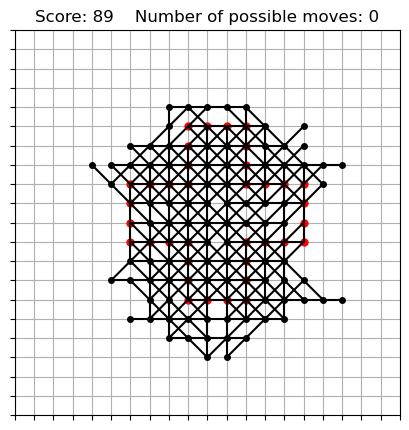

In [10]:
game = PyMorpionSolitaire.Game5T('c')

with torch.no_grad():
    while game.getNumberOfMoves() > 0:
        state = game.image()[48:144, 48:144]
        actions = game.getMoveImages()[:, 48:144, 48:144]
        
        state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
        actions = actions ^ state
        
        x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
        y = net(x).data.squeeze(1)
        i = np.argmax(y).item()
        s = game.getScore()
        game.playByIndex(i)
        print("%3d %7.3f %7.3f %7.3f" % (s, y.min().item(), y.mean().item(), y[i].item()))

game.print()

In [11]:
scores = {1e-6: [game.getScore()]}

In [12]:
def play_random():
    game = PyMorpionSolitaire.Game5T('c')
    game.playAtRandom()
    return game.getScore()

In [13]:
scores[1000] = [play_random() for _ in range(10000)]

In [14]:
def play(t):
    game = PyMorpionSolitaire.Game5T('c')
    while True:
        n = game.getNumberOfMoves()
        if n == 0:
            return game.getScore()
        if n == 1:
            game.playByIndex(0)
        else:
            state = game.image()[48:144, 48:144]
            actions = game.getMoveImages()[:, 48:144, 48:144]
            
            state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
            actions = actions ^ state
            
            x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
            y = net(x).data.squeeze()
            p = torch.exp((y - y.max()) / t)
            p /= p.sum()
            index = np.random.choice(range(len(p)), p=np.array(p))
            game.playByIndex(index)

In [15]:
t_list = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3]
for t in tqdm(t_list):
    if t not in scores:
        scores[t] = []
    for _ in tqdm(range(100), leave=False):
        s = play(t)
        # print(s)
        scores[t] = scores[t] + [s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
scores_mean = {t: np.mean(score, where = np.array(score) > 45).item() for t, score in scores.items()}
sorted(scores_mean.items())

[(1e-06, 89.0),
 (0.0001, 72.65),
 (0.0003, 71.0),
 (0.001, 71.07),
 (0.003, 71.86),
 (0.01, 70.30927835051547),
 (0.03, 67.34343434343434),
 (0.1, 64.57291666666667),
 (0.3, 64.40860215053763),
 (1, 64.2),
 (3, 63.76),
 (1000, 63.69326818675353)]

In [25]:
scores_std = {t: np.std(score, where = np.array(score) > 45).item() for t, score in scores.items()}
sorted(scores_std.items())

[(1e-06, 0.0),
 (0.0001, 6.130864539361475),
 (0.0003, 4.7736651315188405),
 (0.001, 6.945869276051774),
 (0.003, 5.815530930190295),
 (0.01, 4.945811150138091),
 (0.03, 4.472500975177305),
 (0.1, 4.7406592185463925),
 (0.3, 4.470299980648349),
 (1, 3.8157568056677826),
 (3, 4.072149309639812),
 (1000, 4.5562116221812765)]

In [26]:
scores_max = {t: np.max(score).item() for t, score in scores.items()}
sorted(scores_max.items())

[(1e-06, 89),
 (0.0001, 89),
 (0.0003, 83),
 (0.001, 87),
 (0.003, 90),
 (0.01, 87),
 (0.03, 84),
 (0.1, 75),
 (0.3, 84),
 (1, 79),
 (3, 76),
 (1000, 86)]

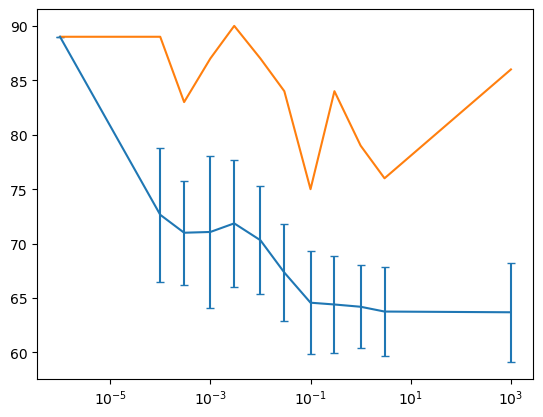

In [27]:
x = sorted(list(scores_mean.keys()))

plt.errorbar(x, [scores_mean[i] for i in x], [scores_std[i] for i in x], capsize = 3)
plt.plot(x, [scores_max[i] for i in x], label="max")
plt.xscale('log')
plt.show()

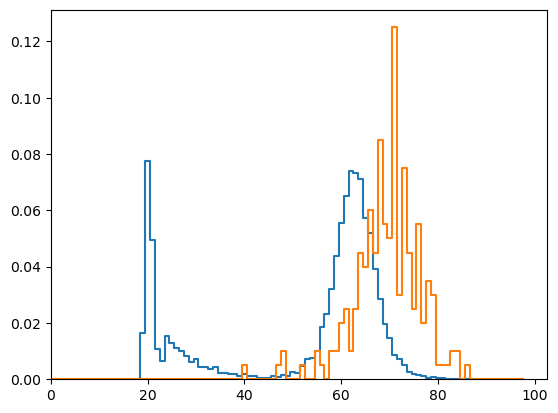

In [45]:
bins = [i - 0.5 for i in range(100)]

dist_0, bins = np.histogram(scores[1000], bins, density=True)
dist, bins = np.histogram(scores[1e-3], bins, density=True)

plt.step(bins[:-1], dist_0)
plt.step(bins[:-1], dist)
plt.xlim(0)
plt.ylim(0)
plt.show()

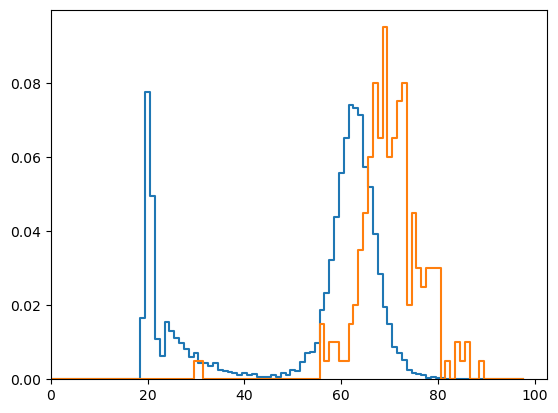

In [46]:
bins = [i - 0.5 for i in range(100)]

dist_0, bins = np.histogram(scores[1000], bins, density=True)
dist, bins = np.histogram(scores[3e-3], bins, density=True)

plt.step(bins[:-1], dist_0)
plt.step(bins[:-1], dist)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [ ]:
# scores[1e-4] = scores[1e-4] + [play(1e-4) for _ in trange(40)]

In [30]:
scores[1e-3] = scores[1e-3] + [play(1e-3) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
scores[3e-3] = scores[3e-3] + [play(3e-3) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]